In [62]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import seaborn as sns
import datetime
import numpy as np
import os
from tqdm import tqdm
from collections import defaultdict
import re

## Setup

### One-time directory setup

In [2]:
base_loc = '.'
population_loc = f'{base_loc}/resources'

# jhu_loc is the root directory of the JHU data repository
jhu_loc = f'{base_loc}/COVID-19'
csse_loc = f'{jhu_loc}/csse_covid_19_data/csse_covid_19_daily_reports'

## Functions for loading data

### Load population and region data

Note: Regions only supported for Pennsylvania in the csv file

In [3]:
def load_population_data():
    """ load population and region data for counties in PA """
    df = pd.read_csv(f'{population_loc}/county-populations.csv')
    
    return df

### Load JHU data

In [4]:
def get_data():
    """ read all the CSV files into a single data frame """
    csv_files = [fname for fname in os.listdir(csse_loc) if fname.endswith('.csv')]
    data = []
    for csv_file in csv_files:
        df = pd.read_csv(f'{csse_loc}/{csv_file}', dtype={"FIPS": str})
        # At some point JHU renamed some columns
        df = df.rename(columns={'Province/State': 'Province_State', 
                                'Last Update': 'Last_Update',
                                'Country/Region': 'Country_Region',
                                'Latitude': 'Lat',
                                'Longitude': 'Long_'})

        data.append(df)

    df = pd.concat(data, ignore_index=True)

    # Remove unneeded columns
    df = df.drop(columns=['Lat', 'Long_', 'Combined_Key', 'FIPS'])
    
    # In later data, "Active" = "Confirmed" - "Deaths". If "Active" == 0, compute it
    

    # Standardize all dates to noon
    df.Last_Update = pd.to_datetime(df.Last_Update)
    df.Last_Update = df.Last_Update.dt.strftime('%m/%d/%Y')
    df.Last_Update = pd.to_datetime(df.Last_Update)

    # Fix "active" column when it is set to 0 prior to it being reported
    def active_fn(row):
        if row.Active == 0:
            return row.Confirmed - row.Recovered - row.Deaths
        else:
            return row.Active

    df = df.assign(Active=df.apply(active_fn, axis=1)) 
    
    return df

In [638]:
def get_series_data():
    """ read the series data in the JHU directory """
    series_loc = f'{jhu_loc}/csse_covid_19_data/csse_covid_19_time_series'
    df = pd.read_csv(f'{series_loc}/time_series_covid19_confirmed_US.csv', dtype={"FIPS": str})
    return df

## Locality Selection

#### Merge and filter all data for just one state

In [5]:
def merge_state(df, state, popdf):
    """ merge individual counties in a state into a single row """
    statepop_dict = state_populations(popdf)

    merged = pd.DataFrame()
    merged['Last_Update'] = df[df.Province_State==state].groupby(df.Last_Update)['Last_Update'].unique()    
    merged['Admin2'] = 'All'
    merged['Province_State'] = state
    merged['Country_Region'] = df.Country_Region.unique()[0]

    merged['Deaths'] = df[df.Province_State==state].groupby(df.Last_Update)['Deaths'].sum()
    merged['Confirmed'] = df[df.Province_State==state].groupby(df.Last_Update)['Confirmed'].sum()
    merged['Recovered'] = df[df.Province_State==state].groupby(df.Last_Update)['Recovered'].sum()
    merged['Active'] = df[df.Province_State==state].groupby(df.Last_Update)['Active'].sum()
    merged['Population'] = statepop_dict[state]

    merged['Last_Update'] = merged.index
    merged.reset_index(drop=True, inplace=True)
    
    return merged

In [36]:
def get_state_data(state, df):
    state_matches = df[(df.Province_State==state)]
    state_matches.reset_index(drop=True, inplace=True)

    return pd.DataFrame(state_matches)

#### Merge for just one region

In [7]:
def merge_region(df, region, popdf):
    """ for PA, merge the data into regions """
    regionpop_dict = region_populations(popdf)
    
    merged = pd.DataFrame()
    merged['Last_Update'] = df[df.Region==region].groupby(df.Last_Update)['Last_Update'].unique()    
    merged['Admin2'] = region
    merged['Province_State'] = df.Province_State.unique()[0]
    merged['Country_Region'] = df.Country_Region.unique()[0]

    merged['Deaths'] = df[df.Region==region].groupby(df.Last_Update)['Deaths'].sum()
    merged['Confirmed'] = df[df.Region==region].groupby(df.Last_Update)['Confirmed'].sum()
    merged['Recovered'] = df[df.Region==region].groupby(df.Last_Update)['Recovered'].sum()
    merged['Active'] = df[df.Region==region].groupby(df.Last_Update)['Active'].sum()

    merged['Population'] = regionpop_dict[region]
    
    merged['Last_Update'] = merged.index
    merged.reset_index(drop=True, inplace=True)

    return merged

#### Filter all data for just one county

In [8]:
def get_county_data(state, county, df):
    county_matches = df[(df.Province_State==state) & (df.Admin2==county)]
    county_matches.reset_index(drop=True, inplace=True)

    return pd.DataFrame(county_matches)

#### Annotate the dataframe with region information, if available

In [178]:
'''
def annotate_regions(df, popdf):
    """ For counties in Pennsylvania, annotate the dataframe with the region """
    
    def annotator(row):
        poprow = popdf[(popdf.State==row.Province_State)&(popdf.County==row.Admin2)]
        if len(poprow) == 0:
            return np.nan
        else:
            return poprow.Region.values[0]

    df['Region'] = df.apply(annotator, axis=1)
'''
pass

In [193]:
def annotate_regions(df, popdf):
    """ Annotate the dataframe with the region, if available (PA and NYC only) """

    region_map = defaultdict(lambda: np.nan)
    for d in popdf.to_dict('records'):
        region_map[d['State'], d['County']] = d['Region']
    df['Region'] = df[['Province_State', 'Admin2']].apply(lambda x: region_map[x[0], x[1]], axis=1)

#### Annotate the dataframe with populations, if available

In [460]:
def annotate_populations(df, popdf):
    """ Annotate the dataframe with populations, if available """
        
    pop_map = defaultdict(lambda: np.nan)
    for d in popdf.to_dict('records'):
        pop_map[d['State'], d['County']] = d['Population']
    df['Population'] = df.loc[:,['Province_State','Admin2']].apply(lambda x: pop_map[x[0], x[1]], axis=1)

In [461]:
def state_populations(popdf):
    return dict(popdf.groupby(popdf.State)['Population'].sum().items())


In [462]:
def region_populations(popdf):
    """ for PA, calculate the population of each region """   
    return dict(popdf.groupby(popdf.Region)['Population'].sum().items())
    

#### Select the appropriate locality

In [463]:
def select_locality(all_df, popdf, query_type, query_state=None, query_region=None, query_county=None):
    if query_type == 'State':
        label = f'{query_state} State'
        df = get_state_data(query_state, all_df)
        df = merge_state(df, query_state, popdf)
    elif query_type == 'Region':
        label = f'{query_region} Region, {query_state}'
        df = get_state_data(query_state, all_df)
        if 'Region' in df.columns:
            df['Admin2'] = df['Region']
        else:
            annotate_regions(df, popdf)
        df = merge_region(df, query_region, popdf)
    elif query_type == 'County':
        label = f'{query_county} County, {query_state}'
        df=get_county_data(query_state, query_county, all_df)
        annotate_populations(df, popdf)
    
    return df, label

### Compute daily and average new cases

In [464]:
def new_cases(df):
    """ given a DataFrame with a .Confirmed field, add a .New_Cases field that
    has new cases per day. """
    df['New_Cases'] = df.Confirmed.subtract(df.Confirmed.shift(1), fill_value=0)
    return df

In [15]:
def average_new_cases(df, days, centered=False):
    """ this computes day the trailing average in the final day """
    """ compute the moving average over {days} days and add as day_avg_{days} to the df """
    field = f'day_avg_{days}'
    df[field] = df.New_Cases.rolling(window=14, min_periods=1, center=centered).mean()

In [16]:
def date_avg(dates):
  refdate = datetime.datetime(2019, 1, 1)
  return refdate + sum([date - refdate for date in dates], datetime.timedelta()) / len(dates)

## Functions for graphing

### Daily new cases and 7-day moving average

In [17]:
def new_case_plot(df, label, days=7, centered=False, output=None):

    if centered:
        date_field = f'Centered_Date_{days}'
    else:
        date_field='Last_Update'
    average_new_cases(df, days, centered=centered)

        
    g = sns.lineplot(df['Last_Update'], df['New_Cases'], label="Daily new cases")
    sns.lineplot(df[date_field], df[f'day_avg_{days}'], ax=g, label=f"{days} day moving average")
    g.set(xlabel="\nDate", ylabel="New Cases", title=f"New Cases Per Day\n{label}")
    leg = g.legend(loc='upper left', frameon=False)
    plt.xticks(rotation=90)
    if output == None:
        plt.show()
    else:
        output = output.replace('.png', '_new_cases.png')
        plt.savefig(output, bbox_inches='tight')


### Yellow target: 50 new cases over 14 days per 100K people

In [18]:
def newcase_sum(df, days, perpop=1):
    """ 
    compute the sum of {days} days and {days}_sum to the df 
    if perpop is not 1, calculate the same weighted by the population pop
    """
    field = f'sum_{days}'
    df[field] = df.New_Cases.rolling(window=days, min_periods=1).sum()
    df[field] *= perpop

In [19]:
def yellow_target(df, label, output=None):
    population = set(df.Population).pop()
    newcase_sum(df, 14, perpop=100000/population)
    target = 50
    
    g = sns.lineplot(df['Last_Update'], df['sum_14'], label="14 day caseload per 100K")
    sns.lineplot(df['Last_Update'], [target]*len(df), label="Yellow Target", ax=g)
    g.set(xlabel="\nDate", ylabel="14 days cases per 100K", title=f"Progress towards yellow target\n{label}")
    leg = g.legend(loc='lower right', frameon=False)
    plt.xticks(rotation=90)
    if output == None:
        plt.show()
    else:
        output = output.replace('.png', '_yellow_target.png')
        plt.savefig(output, bbox_inches='tight')

### Days trending downward in 14 days

In [20]:
def limit_xticks(labels, num=5):
    """
    For some reason I can't limit the number of xticks so here I'm
    just doing it myself by erasing the text of the xticks I don't want
    """
        
    target_ticks = set([0, len(labels)-1])
    for i in range(1, num-1):
        pos= int(round(len(labels)/(num-1)*i,0))
        target_ticks.add(pos)

    for i, lab in enumerate(labels):
        if i not in target_ticks:
            labels[i].set_text("")
    return labels

In [21]:
def fit(period):
    if len(period) == 1:
        return 0
    else:
        m, b = np.polyfit(np.arange(len(period)), period, 1)
        return m

In [22]:
def trend(df, days):
    """ 
    compute the trendline for the past {days} days as slope_{days} and
    the number of days within those {days} that the trend is worsening 
    (positive) or improving (negative) as {days}_trend
    """
    slopes = []
    trends = []

    # Get the slope of the trend line for the past {days} days.
    sfield=f'slope_{days}'
    df[sfield] = df.New_Cases.rolling(window=days, min_periods=1).apply(fit)

    # Get the number of times the slope was positive in last {days} days.
    field = f'trend_{days}'
    df[field] = df[sfield].rolling(window=14, min_periods=14).apply(lambda x: (x>0).sum())

    return df

In [23]:
def trending(df, label, days=14, output=None):
    df = trend(df, 14)

    tfield = f'trend_{days}'
    sfield = f'slope_{days}'
    
    formatted_dates = df['Last_Update'].apply(lambda x: x.strftime('%Y-%m-%d'))
    g=sns.barplot(formatted_dates, df[tfield], label="increasing trends", color='red')
    sns.barplot(formatted_dates, df[tfield]-14, label="decreasing trends", color='green')
    t = g.twinx()
    
    sns.lineplot(np.arange(len(df)), df[sfield], color="black", label="14-day slope", ax=t)
    #slopes = np.where(df['trend_14'].isnull(), 0, df['slope_14'])
    #sns.lineplot(np.arange(len(df)), slopes, color="black", label="14-day slope", ax=t)

    labels = limit_xticks(g.get_xticklabels())
    g.set_xticklabels(labels,rotation=90)

    g.set_ylim(-14,14)
    title=f"Number of days in the past two weeks with a positive or negative trend\n{label}"
    g.set(xlabel="\nDate", ylabel="Number of days", title=title)
    t.set(ylabel="slope of 14-day trend")
    slope_lim = max(abs(df[df[sfield].notna()][sfield]))*1.1
    t.set_ylim(-slope_lim,slope_lim)
    leg = t.legend(loc='lower left', frameon=False)

    if output is None:
        plt.show()
    else:
        output = output.replace('.png', '_trend.png')
        plt.savefig(output, bbox_inches='tight')
    

## Read data

#### Issues

* States allocate cases to "Unassigned" if county is unknown
* "Out of CO", "Out of GA", "Out of MI", "Out of OK", "Out of TN" is listed as a county
* Dukes, MA and Nantucket, MA -> "Dukes and Nantucket"
* Federal Correctional Institution (FCI), MI; Michigan Department of Corrections (MDOC), MI
* Kansas City, MO reported as a standalone county when it actually appears in multiple counties
* New York City, NY is reported but counties are Richmond, Queens, New York, Kings and Bronx
* Counties in Utah don't align

### Read JHU data

In [24]:
all_df = get_data()

### Read county population data

In [25]:
popdf = load_population_data()

## Output all graphs for specified state, region or county

In [627]:
def pipeline_helper(df, label, output, output_directory):
    df = df.sort_values(by='Last_Update', ignore_index=True)
    if output == 'png':
        output = label.replace(' ','_') + '.png'
        output = output.replace(',','')
        if output_directory==None:
            output_directory='png'
        output = f"{output_directory}/{output}"
    else:
        output = None
    
    new_cases(df) # add a new_cases column to the dataframe
    new_case_plot(df, label, days=14, centered=False, output=output)    
    plt.close()
    yellow_target(df, label, output=output)
    plt.close()
    trending(df, label, output=output)
    plt.close()
    
    return df


In [633]:
def run_pipeline(all_df, popdf, query_type, query_state=None, query_region=None, query_county=None, output=None, 
                output_directory=None):
    """ 
    Run pipeline on daily_reports data
    """
    assert query_type in ['State', 'County', 'Region']
    assert output in ['inline', 'png']

    df, label = select_locality(all_df, popdf, query_type, query_state, query_region, query_county)
    return pipeline_helper(df, label, output, output_directory)

In [646]:
def run_pipeline_series(all_sdf, popdf, query_type, query_state=None, query_region=None, query_county=None, output=None, 
                output_directory=None):
    """
    Run pipeline on time_series data
    """
    assert query_type in ['State', 'County', 'Region']
    assert output in ['inline', 'png']

    df = select_locality_series(all_sdf, popdf, query_type, query_state, query_region, query_county)
    label = df.Combined_Key.values[0]
    return pipeline_helper(df, label, output, output_directory)
    

## Generate state graphs

In [27]:
#states = ['Pennsylvania', 'Georgia', 'New York', 'Florida', 'New Jersey']
#states = ['Pennsylvania']
states = ['Georgia', 'New York', 'Florida', 'New Jersey']
#states = ['Pennsylvania']
#states = []
statedir = 'states'
for state in states:
    print(state)
    outdir = f'{statedir}/{state}'.replace(' ','_')
    counties = set(popdf[popdf.State==state].County)

    if state == 'New York': # remove NYC counties; JHU conflates into a single county
        counties -= set(['Bronx', 'New York', 'Kings', 'Queens', 'Richmond', 'New York City'])

    state_df = get_state_data(state, all_df)
    #state_df = all_df

    pbar = tqdm(sorted(counties))
    for county in pbar:
        pbar.set_description(f"{state}:{county:20}")
        run_pipeline(state_df, popdf, query_type="County", query_state=state, query_county=county, output="png",
                    output_directory=outdir)
        
    # Annotate Regions
    region_map = defaultdict(lambda: np.nan)
    for d in popdf.to_dict('records'):
        region_map[d['State'], d['County']] = d['Region']
    state_df['Region'] = state_df[['Province_State', 'Admin2']].apply(lambda x: region_map[x[0], x[1]], axis=1)
    
    regions = set(popdf.Region[(popdf.Region.notnull()) & (popdf.State==state)])

    pbar = tqdm(sorted(regions))
    for region in pbar:
        pbar.set_description(f"{state}:{region:20}")
        df = run_pipeline(state_df, popdf, query_type="Region", query_state=state, query_region=region, output="png",
                     output_directory=outdir)
        
    run_pipeline(state_df, popdf, query_type="State", query_state=state, output='png',
                 output_directory=outdir)

print(f"All states completed.")

Pennsylvania:Adams               :   0%|          | 0/67 [00:00<?, ?it/s]

Pennsylvania


Pennsylvania:South West          : 100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


All states completed.


## One-off graphs

### Setup variables for this run

In [30]:
one_off=False
if one_off:
    query_type='Region'
    query_state='New York'
    query_region='New York City'
    query_county=None
    output='png'
    output_dir='png'
    df = run_pipeline(all_df, popdf, query_type="Region", query_state=query_state, query_county=query_county, 
                      query_region=query_region, output="png", output_directory=outdir)

### TRY OUT TIME SERIES DATA

In [579]:
def simplify_columns(df, date_cols=None):
    if not date_cols:
        # find which columns are dates
        rgx = re.compile(r'\d+/\d+/\d+')
        date_cols = [c for c in df.columns if rgx.search(c)]
    #reorder = ['Province_State', 'Admin2', 'Country_Region', 'Combined_Key', 'Population', 'Region'] + date_cols
    reorder = ['Admin2', 'Province_State', 'Country_Region', 'Combined_Key', 'Population'] + date_cols
    df = df[reorder]
    return df

In [580]:
def merge_state_series(sdf, popdf, state=None):
    merged = pd.DataFrame()

    # verify there is only one state here --> if not, select it using the paramater
    if len(set(sdf['Province_State'])) > 1:
        sdf = get_state_data(state, sdf)
    else: 
        state = sdf['Province_State'].values[0]
        
    # verify there is at least one row here
    assert len(sdf) > 0

    # find which columns are dates
    rgx = re.compile(r'\d+/\d+/\d+')
    date_cols = [c for c in sdf.columns if rgx.search(c)]

    # Merge confirmed case totals
    for date in date_cols:
        merged[date] = sdf.groupby(sdf['Province_State'])[date].sum()
    merged['Province_State'] = state
    merged['Admin2'] = 'All'
    merged['Country_Region'] = sdf['Country_Region'].values[0]
    merged['Combined_Key'] = f'{state} State'
    merged['Population'] = sdf.groupby(sdf['Province_State'])['Population'].sum()

    merged = simplify_columns(merged, date_cols)

    merged.reset_index(drop=True, inplace=True)
    
    return merged

In [581]:
def merge_region_series(sdf, popdf, region=None):
    merged = pd.DataFrame()

    # verify there is only one region here --> if not, select it using the paramater
    if len(set(sdf['Region'])) > 1:
        region_matches = sdf[(sdf.Region==region)]
        region_matches.reset_index(drop=True, inplace=True)
        sdf = pd.DataFrame(region_matches)
    else:
        region = sdf['Region'].values[0]
        
    state = sdf['Province_State'].values[0]
        
    # verify there is at least one row here
    assert len(sdf) > 0

    # find which columns are dates
    rgx = re.compile(r'\d+/\d+/\d+')
    date_cols = [c for c in sdf.columns if rgx.search(c)]

    # Merge confirmed case totals
    for date in date_cols:
        merged[date] = sdf.groupby(sdf['Province_State'])[date].sum()
    merged['Province_State'] = state
    merged['Admin2'] = region
    merged['Country_Region'] = sdf['Country_Region'].values[0]
    merged['Combined_Key'] = f'{region} Region, {state}'

    merged = simplify_columns(merged, date_cols)
    
    merged.reset_index(drop=True, inplace=True)

    return merged

In [582]:
def get_county_data_series(state, county, df):
    merged = df[(df.Province_State==state) & (df.Admin2==county)]
    df['Combined_Key'] = f'{county} County, {state}'

    merged = simplify_columns(merged)
    merged.reset_index(drop=True, inplace=True)
    
    return pd.DataFrame(merged)

In [623]:
def transpose(sdf):
    """ Convert the single-row time series JHU data to the table format """
    
    # Assumes a single row
    assert len(sdf) == 1
    
    # Save columns to a dictionary so we can retrieve later
    keys = sdf.to_dict('records')[0]
    rgx = re.compile(r'\d+/\d+/\d+')
    non_date_cols = [c for c in sdf.columns if not rgx.search(c)]
    sdf = sdf.drop(columns=non_date_cols)

    # Transpose the data
    df = sdf.transpose()

    # Copy column 0 into Confirmed (otherwise reseting the index deletes this)
    df['Confirmed'] = df[0]

    # Create Last_Update column from the index and standardize dates to noon each day
    df['Last_Update'] = df.index
    df.Last_Update = pd.to_datetime(df.Last_Update)
    df.Last_Update = df.Last_Update.dt.strftime('%m/%d/%Y')
    df.Last_Update = pd.to_datetime(df.Last_Update)
    
    # Restore the non-date values into the columns
    for col in non_date_cols:
        df[col] = keys[col]
    
    # Reindex
    df.reset_index(drop=True,inplace=True)

    # Reorder columns
    df = df[['Last_Update', 'Confirmed'] + non_date_cols]

    return df



In [624]:
def select_locality_series(sdf_all_all, popdf, query_type, query_state=None, query_region=None, query_county=None):
    if 'Region' not in sdf_all:
        annotate_regions(sdf_all, popdf)
    if 'Population' not in sdf_all:
        annotate_populations(sdf_all, popdf)
    if query_type == 'State':
        df = get_state_data(query_state, sdf_all) # OK
        df = merge_state_series(df, popdf) # Rewritten
    elif query_type == 'Region':
        df = get_state_data(query_state, sdf_all) # OK
        df = merge_region_series(df, popdf, region=query_region) # Rewritten
    elif query_type == 'County':
        df = get_county_data_series(query_state, query_county, sdf_all) # Rewritten
    
    return transpose(df)

In [639]:
sdf_all = get_series_data()

In [642]:
query_state

'Pennsylvania'

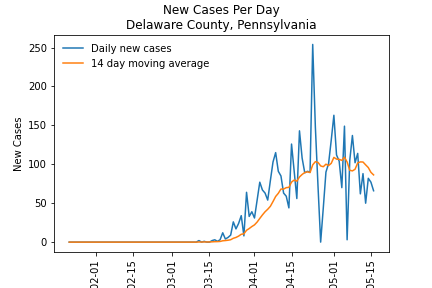

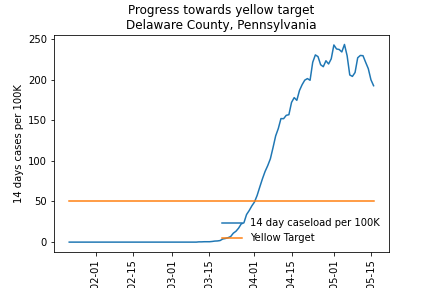

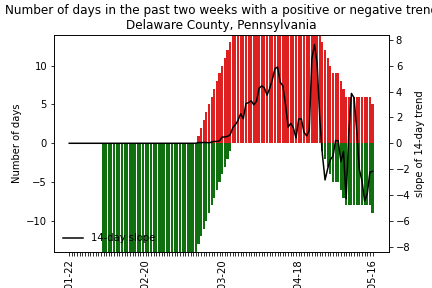

In [648]:
one_off=True
if one_off:
    q_type='County'
    q_state='Pennsylvania'
    q_region='South East'
    q_county='Bucks'
    output='inline'
    output_dir='png'
    df = run_pipeline_series(sdf_all, popdf, q_type, query_state=q_state, query_county=q_county, 
                             query_region=q_region, output=output, output_directory=outdir)